### Text Summarization

Summarization is an important task in natural language processing and could be useful for a consumer enterprise. For example, bots can be used to scrape articles, summarize them, and then you can use sentiment analysis to identify the sentiment about certain stocks. This project covers the folllowing:

- Use built-in functions to preprocess your data
- Implement DotProductAttention
- Implement Causal Attention
- Understand how attention works
- Build the transformer model
- Evaluate your model
- Summarize an article

In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import utils

import textwrap
wrapper = textwrap.TextWrapper(width=70)

tf.keras.utils.set_random_seed(10)

2025-03-16 11:58:59.642952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742151539.661815   70157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742151539.667699   70157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 11:58:59.694924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Imprting dataset

In [2]:
data_dir = "data/corpus"

train_data, test_data = utils.get_train_test_data(data_dir)

# Take one example from the dataset and print it
example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue:\n{example_dialogue}")
print(f"\nSummary:\n{example_summary}")

Dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


### Preprocessing the data

First you will do some preprocessing of the data and split it into inputs and outputs. Here you also remove some of the characters that are specific to this dataset and add the `[EOS]` (end of sentence) token to the end. You will also add a `[SOS]` (start of sentence) token to the beginning of the sentences.

In [3]:
document, summary = utils.preprocess(train_data)
document_test, summary_test = utils.preprocess(test_data)

Now perform the standard preprocessing with the tensorflow library. You will need to modify the filters, because you dont want the `[EOS]` tokens to be removed.

Then create the vocabulary by combining the data in the documents and the summaries and using `.fit_on_texts()`:

In [4]:
# The [ and ] from default tokens cannot be removed, because they mark the SOS and EOS token.
filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
oov_token = '[UNK]'

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token, lower=False)

documents_and_summary = pd.concat([document, summary], ignore_index=True)

tokenizer.fit_on_texts(documents_and_summary)

inputs = tokenizer.texts_to_sequences(document)
targets = tokenizer.texts_to_sequences(summary)

vocab_size = len(tokenizer.word_index) + 1

print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


Now you can pad the tokenized sequences for the training data.

For the purpose of this project you need to limit the length of the sequences, as transformers are really big models and are not meant to be trained in such small environments.

In [5]:
encoder_maxlen = 150
decoder_maxlen = 50

# Pad the sequences.
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 16

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

I0000 00:00:1742151544.987562   70157 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data is automatically fed into your model. However, when you train a Transformer network using multi-head attention, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful.

In [6]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        d_model (int): Encoding size 
    
    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """
    
    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2
    
    # initialize a matrix angle_rads of all the angles 
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    # print(pos_encoding.shape)
    return tf.cast(pos_encoding, dtype=tf.float32)

### Masking

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence. 

In [7]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids (matrix like): matrix of size (n, m)
    
    Returns:
        mask (tf.Tensor): binary tensor of size (n, 1, m)
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :] 


def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length (int): matrix size
    
    Returns:
        mask (tf.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

### Self Attention

The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

In [8]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q (tf.Tensor): query of shape (..., seq_len_q, depth)
        k (tf.Tensor): key of shape (..., seq_len_k, depth)
        v (tf.Tensor): value of shape (..., seq_len_v, depth_v)
        mask (tf.Tensor): mask with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    matmul_qk = tf.linalg.matmul(q,k,transpose_b=True)
#     print(k.shape)
#     print(q.shape)
#     print(v.shape)
    # scale matmul_qk with the square root of dk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)
    # print(mask)
    # print(scaled_attention_logits)
    # add the mask to the scaled tensor.
    if mask is not None: 
        scaled_attention_logits += (1.0-mask)*-1e9
    # print(scaled_attention_logits)
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.keras.activations.softmax(
    scaled_attention_logits, axis=-1
)

    # Multiply the attention weights by v
    output = tf.linalg.matmul(attention_weights,v)

    return output, attention_weights

In [9]:
# Test your function!
q = np.array([[1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [1, 1, 1, 0], [0, 0, 0, 1], [0, 1, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]).astype(np.float32)
mask = np.array([[[0, 1, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 1, 1]]])

ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = np.around(ou, decimals=2)
atw = np.around(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weights:\n {atw}")

Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weights:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]


### Encoder

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder.

* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.

In [10]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        _ (tf.keras.Model): sequential model
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

### Encoder Layer

Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training.

 The encoder block performs the following steps: 
1. It takes the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K are the same. You will also perform Dropout in this multi-head attention layer during training. 
2. There is a skip connection to add your original input `x` and the output of the multi-head attention layer. 
3. After adding the skip connection, the output passes through the first normalization layer.
4. Finally, steps 1-3 are repeated but with the feed forward neural network with a dropout layer instead of the multi-head attention layer. 


In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        
        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, fully_connected_dim)
        
        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to ffn output during training
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output
        # to get the output of the encoder layer
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        
        return encoder_layer_out
    

### Full Encoder

Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embed your input and add the positional encodings you calculated. The Encoder class performs the following steps: 
1. Pass the input through the Embedding layer.
2. Scale the embedding by multiplying it by the square root of the embedding dimension. 
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to the embedding.
4. Pass the encoded embedding through a dropout layer
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [12]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding dim)
        """
        seq_len = tf.shape(x)[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, embedding_dim)

### Decoder
Now it is time to implement the decoder. The Decoder layer takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output


In [13]:

class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor): Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            out3 (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, target_seq_len)
            attn_weights_block2 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(x,x,x,attention_mask=look_ahead_mask,return_attention_scores=True)
        
        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x+mult_attn_out1)
#         print(Q1.shape)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output. 
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line) 
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1,enc_output,enc_output,attention_mask=padding_mask,return_attention_scores=True)
        
        # # apply layer normalization (layernorm2) to the sum of the attention output and the Q from the first block (~1 line)
        mult_attn_out2 = self.layernorm2(Q1+mult_attn_out2)
       
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)
        
        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output,training=training)
        
        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output+mult_attn_out2)

        return out3, attn_weights_block1, attn_weights_block2
    

In [14]:
# Test your function!
key_dim = 12
n_heads = 16

decoderLayer_test = DecoderLayer(embedding_dim=key_dim, num_heads=n_heads, fully_connected_dim=32)

q = np.ones((1, 15, key_dim))
encoder_test_output = tf.convert_to_tensor(np.random.rand(1, 7, 8))
look_ahead_mask = create_look_ahead_mask(q.shape[1])

out, attn_w_b1, attn_w_b2 = decoderLayer_test(x=q, enc_output=encoder_test_output, training=False, look_ahead_mask=look_ahead_mask, padding_mask=None)

print(f"Using embedding_dim={key_dim} and num_heads={n_heads}:\n")
print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder layer has shape:{out.shape}")
print(f"Att Weights Block 1 has shape:{attn_w_b1.shape}")
print(f"Att Weights Block 2 has shape:{attn_w_b2.shape}")

Using embedding_dim=12 and num_heads=16:

q has shape:(1, 15, 12)
Output of encoder has shape:(1, 7, 8)

Output of decoder layer has shape:(1, 15, 12)
Att Weights Block 1 has shape:(1, 16, 15, 15)
Att Weights Block 2 has shape:(1, 16, 15, 7)


### Full Decoder

Implement `Decoder()` using the `call()` method to embed your output, add positional encoding, and implement multiple decoder layers.
 
Here, you will initialize your Decoder with an Embedding layer, positional encoding, and multiple DecoderLayers. Your `call()` method will perform the following steps: 
1. Pass your generated output through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
5. Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

In [15]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len)
            enc_output (tf.Tensor):  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
    
        # create word embeddings 
        x = self.embedding(x)
       
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # add positional encodings to word embedding
        x += self.pos_encoding[:,:seq_len,:]
        
        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x,training=training)
        
        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x,enc_output,training=training,look_ahead_mask=look_ahead_mask,padding_mask=padding_mask)
#             print(x.shape)
            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights[f'decoder_layer{i+1}_block1_self_att']=block1
            attention_weights[f'decoder_layer{i+1}_block2_self_att']=block2
            
#         print(x.shape)
        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

In [16]:
# Test your function!
n_layers = 5
emb_d = 13
n_heads = 17
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x = np.array([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]])

encoder_test_output = tf.convert_to_tensor(np.random.rand(3, 7, 9))

look_ahead_mask = create_look_ahead_mask(x.shape[1])

decoder_test = Decoder(n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size,maximum_position_encoding)
                   
outd, att_weights = decoder_test(x, encoder_test_output, training=False, look_ahead_mask=look_ahead_mask,padding_mask= None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer1_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer1_block2_self_att has shape:(3, 17, 4, 7)
decoder_layer2_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer2_block2_self_att has shape:(3, 17, 4, 7)
decoder_layer3_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer3_block2_self_att has shape:(3, 17, 4, 7)
decoder_layer4_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer4_block2_self_att has shape:(3, 17, 4, 7)
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_self_att has shape:(3, 17, 4, 7)


### Transformer

    
The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in your sequence.

In [17]:

class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len)
                              An array of the indexes of the words in the input sentence
            output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len)
                              An array of the indexes of the words in the output sentence
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            final_output (tf.Tensor): The final output of the model
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence,training=training,mask=enc_padding_mask)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence,enc_output,training=training,look_ahead_mask=look_ahead_mask,padding_mask=dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~1 line)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [18]:
# Test your function!
n_layers = 3
emb_d = 13
n_heads = 17
fully_connected_dim = 8
input_vocab_size = 300
target_vocab_size = 350
max_positional_encoding_input = 12
max_positional_encoding_target = 12

transformer = Transformer(n_layers, 
    emb_d, 
    n_heads, 
    fully_connected_dim, 
    input_vocab_size, 
    target_vocab_size, 
    max_positional_encoding_input,
    max_positional_encoding_target)

# 0 is the padding value
sentence_a = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b = np.array([[1, 3, 4, 0, 0, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_a)
dec_padding_mask = create_padding_mask(sentence_a)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1])

test_summary, att_weights = transformer(
    sentence_a,
    sentence_b,
    training=False,
    enc_padding_mask=enc_padding_mask,
    look_ahead_mask=look_ahead_mask,
    dec_padding_mask=dec_padding_mask
)

print(f"Using num_layers={n_layers}, target_vocab_size={target_vocab_size} and num_heads={n_heads}:\n")
print(f"sentence_a has shape:{sentence_a.shape}")
print(f"sentence_b has shape:{sentence_b.shape}")

print(f"\nOutput of transformer (summary) has shape:{test_summary.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:(1, 7)
sentence_b has shape:(1, 7)

Output of transformer (summary) has shape:(1, 7, 350)

Attention weights:
decoder_layer1_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer1_block2_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block2_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block2_self_att has shape:(1, 17, 7, 7)


### Inititalize the model

Now that you have defined the model, you can initialize and train it. First you can initialize the model with the parameters below. Note that generally these models are much larger and you are using a smaller version to fit this environment and to be able to train it in just a few minutes.

The base model described in the original Transformer paper used `num_layers=6`, `embedding_dim=512`, and `fully_connected_dim=2048`.

In [19]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

# Initialize the model
transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads, 
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
)

### Preparing the transformer

The original transformer paper uses Adam optimizer with custom learning rate scheduling, which we define in the cell below. This was empirically shown to produce faster convergence.

In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

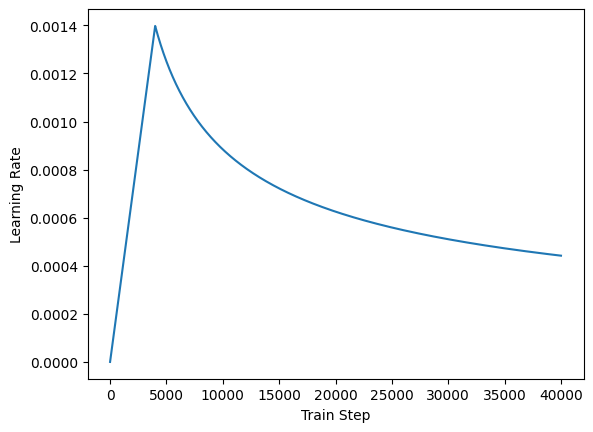

In [21]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Next, you set up the loss. Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

You will use the sparse categorical cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`) and set the parameter `from_logits` to False since the Transformer does not output raw logits since the last layer has a softmax activation:

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')

# Here you will store the losses, so you can later plot them
losses = []

Now you can define your custom training function. If you are not very advanced with tensorflow, you can understand this function as an alternative to using `model.compile()` and `model.fit()`, but with added extra flexibility.

In [23]:
@tf.function
def train_step(model, inp, tar):
    """
    One training step for the transformer
    Arguments:
        inp (tf.Tensor): Input data to summarize
        tar (tf.Tensor): Target (summary)
    Returns:
        None
    """
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Create masks
    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = create_padding_mask(inp) # Notice that both encoder and decoder padding masks are equal

    with tf.GradientTape() as tape:
        predictions, _ = model(
            inp,
            tar_inp, 
            training=True, 
            enc_padding_mask =enc_padding_mask, 
            look_ahead_mask=look_ahead_mask, 
            dec_padding_mask=dec_padding_mask
        )
        loss = masked_loss(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

### Summarization

The last thing you will implement is inference. With this, you will be able to produce actual summaries of the documents. You will use a simple method called greedy decoding, which means you will predict one word at a time and append it to the output. You will start with an `[SOS]` token and repeat the word by word inference until the model returns you the `[EOS]` token or until you reach the maximum length of the sentence (you need to add this limit, otherwise a poorly trained model could give you infinite sentences without ever producing the `[EOS]` token.

In [24]:
def next_word(model, encoder_input, output):
    """
    Helper function for summarization that uses the model to predict just the next word.
    Arguments:
        encoder_input (tf.Tensor): Input data to summarize
        output (tf.Tensor): (incomplete) target (summary)
    Returns:
        predicted_id (tf.Tensor): The id of the predicted word
    """
    # Create a padding mask for the input (encoder)
    enc_padding_mask = create_padding_mask(encoder_input)
    # Create a look-ahead mask for the output
    look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
    # Create a padding mask for the input (decoder)
    dec_padding_mask = create_padding_mask(encoder_input)

    # Run the prediction of the next word with the transformer model
    predictions, attention_weights = model(
        encoder_input,
        output,
        training=False,
        enc_padding_mask=enc_padding_mask,
        look_ahead_mask=look_ahead_mask,
        dec_padding_mask=dec_padding_mask
    )
    predictions = predictions[: ,-1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    return predicted_id

In [25]:
# Take a random sentence as an input
input_document = tokenizer.texts_to_sequences(["a random sentence"])
input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
encoder_input = tf.expand_dims(input_document[0], 0)

# Take the start of sentence token as the only token in the output to predict the next word
output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

# predict the next word with your function
predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.sequences_to_texts(predicted_token.numpy())[0]
print(f"Predicted word: {predicted_word}")

/home/uday/miniconda3/envs/tf_2.18/lib/python3.9/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Predicted token: [[1940]]
Predicted word: cancel


In [26]:
def summarize(model, input_document):
    """
    A function for summarization using the transformer model
    Arguments:
        input_document (tf.Tensor): Input data to summarize
    Returns:
        _ (str): The summary of the input_document
    """    
    input_document = tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    encoder_input = tf.expand_dims(input_document[0], 0)
    
    output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)
    
    for i in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = tf.concat([output, predicted_id], axis=-1)
        
        if predicted_id == tokenizer.word_index["[EOS]"]:
            break

    return tokenizer.sequences_to_texts(output.numpy())[0]  # since there is just one translated document

In [27]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


"[SOS] cancel sixtynine sixtynine sixtynine advises graetful uoft sandstorm ellie's aligning aligning aligning aligning barb barb trimmings scaffoldings 128gb emerson prosecuted kayla's gabi acetone acetone bourgeois waitresses uninvited splitting success hurts calluses likke waitresses uninvited likke tuesdays eek miserable likke tuesdays eek tuesdays acetone labialized labialized riki honney likke uuu bred"

In [28]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


### Training the model


In [29]:
# Take an example from the test set, to monitor it during training
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

# Define the number of epochs
epochs = 20

# Training loop
for epoch in range(epochs):
    
    start = time.time()
    train_loss.reset_state()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        train_step(transformer, inp, tar)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document)}\n')

2025-03-16 11:59:16.459925: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-16 12:00:30.417448: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss 6.8690
Time taken for one epoch: 74.14595341682434 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] tom is going to the new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new new



2025-03-16 12:01:37.897038: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss 5.7932
Time taken for one epoch: 63.422964096069336 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] tom and tom are going to the party for the party at the party [EOS]

Epoch 3, Loss 5.484721
Time taken for one epoch: 63.68301820755005 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] tom is going to the new job [EOS]

Epoch 4, Loss 5.294521
Time taken for one epoch: 63.34865379333496 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:


2025-03-16 12:03:46.677606: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    [SOS] tom is going to buy a new year's eve [EOS]

Epoch 5, Loss 5.132921
Time taken for one epoch: 63.647510290145874 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] mike and mary are going to the party with her [EOS]

Epoch 6, Loss 4.976821
Time taken for one epoch: 63.55939507484436 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] anna is going to the party with her [EOS]

Epoch 7, Loss 4.817421
Time taken for one epoch: 62.64049816131592 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] emily is going to meet with her and she is

2025-03-16 12:08:04.148368: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    [SOS] emily is going to meet with her house and she will meet with her [EOS]

Epoch 9, Loss 4.524221
Time taken for one epoch: 64.04388451576233 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] emma is looking for a dog for her and she will meet with her [EOS]

Epoch 10, Loss 4.391921
Time taken for one epoch: 64.20036101341248 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] hannah is looking for a place to meet with her [EOS]

Epoch 11, Loss 4.265321
Time taken for one epoch: 64.02613139152527 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarizatio

2025-03-16 12:16:34.456710: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16, Loss 3.7222
Time taken for one epoch: 62.09886622428894 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] jane is looking for a place for her number to her [EOS]

Epoch 17, Loss 3.626521
Time taken for one epoch: 62.98169755935669 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] jane is looking for a place to check if she has already seen her number [EOS]

Epoch 18, Loss 3.540721
Time taken for one epoch: 64.29552125930786 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] amanda is looking for a girl to the park for her [EOS]



Text(0.5, 0, 'Epoch')

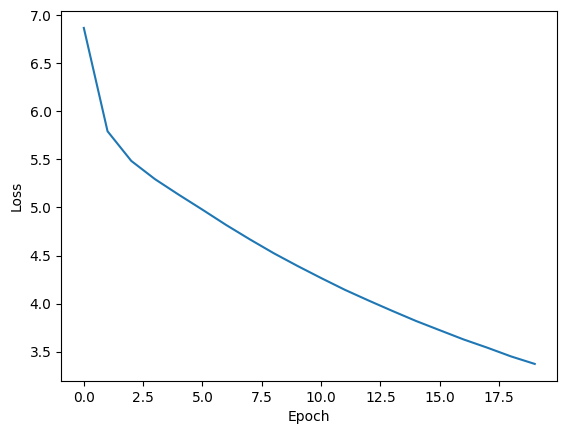

In [30]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

### Summarize some Sentences

In [34]:

training_set_example = 5

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

Training set example:
[SOS] neville: hi there, does anyone remember what date i got married on?  don: are you serious?  neville: dead serious. we're on vacation, and tina's mad at me about something. i have a strange suspicion that this might have something to do with our wedding anniversary, but i have nowhere to check.  wyatt: hang on, i'll ask my wife.  don: haha, someone's in a lot of trouble :d  wyatt: september 17. i hope you remember the year ;) [EOS]

Human written summary:
[SOS] wyatt reminds neville his wedding anniversary is on the 17th of september. neville's wife is upset and it might be because neville forgot about their anniversary. [EOS]

Model written summary:
[SOS] ollie is on the date of the wedding post is on the wedding way is on the wedding way and he will ask don [EOS]


In [35]:
test_set_example = 3

# Check a summary of a document from the test set
print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Test set example:
[SOS] will: hey babe, what do you want for dinner tonight?  emma:  gah, don't even worry about it tonight  will: what do you mean? everything ok?  emma: not really, but it's ok, don't worry about cooking though, i'm not hungry  will: well what time will you be home?  emma: soon, hopefully  will: you sure? maybe you want me to pick you up?  emma: no no it's alright. i'll be home soon, i'll tell you when i get home.   will: alright, love you.   emma: love you too.  [EOS]

Human written summary:
[SOS] emma will be home soon and she will let will know. [EOS]

Model written summary:
[SOS] emma will pick up up tonight and she will pick her up [EOS]


If you critically examine the output of the model, you can notice a few things:
 - In the training set the model output is (almost) identical to the real output (already after 20 epochs and even more so with more epochs). This might be because the training set is relatively small and the model is relatively big and has thus learned the sentences in the training set by heart (overfitting).
 - While the performance on the training set looks amazing, it is not so good on the test set. The model overfits, but fails to generalize. Again an easy candidate to blame is the small training set and a comparatively large model, but there might be a variety of other factors.
 - Look at the test set example 3 and its summarization. Would you summarize it the same way as it is written here? Sometimes the data may be ambiguous. And the training of **your model can only be as good as your data**.

Here you only use a small dataset, to show that something can be learned in a reasonable amount of time in a relatively small environment. Generally, large transformers are trained on more than one task and on very large quantities of data to achieve superb performance. You will learn more about this in the rest of this course.